In [1]:
import numpy as np
from random import choices, randrange
import random
import matplotlib.pyplot as plt
from numba import njit
from sklearn.datasets import make_blobs
from utility import *
from tqdm import tqdm

# Simulated Annealing

Implementazione dell'algoritmo di simulated annealing per la soluzione del problema di clustering.

L'algoritmo parte da una soluzione di bassa qualità realizzata tramite un semplice algoritmo che inizializza casualmente i centroidi e che associa ogni punto al cluster con il centroide più vicino.

Data una soluzione la soluzione candidato, che viene valutata per ogni iteazione del SA è ottenuta selezionando un nodo casualmente e spostandolo da un cluster ad un altro.

La funzione change_sol effettua la mossa sopra descritta per generare la soluzione candidato.

La funzione simulated annealing richiede l'inizializzazione di quattro parametri:
*   $T_i$ e $T_f$ : rispettivamente la temperatura iniziale e finale dell'algoritmo. La prima regola la probabilità con il quale soluzioni pegiorative sono accettate, l'altra è utilizzata per il criterio d'arresto.
*   $\alpha$ : Il parametro di raffreddamento, tra un'iterazione e la successiva la temperatura è ridotta secondo la seguente legge esponenziale : $T_{k+1} = \alpha * T_k$.
Un parametro di $\alpha$ prossimo ad 1 garantisce un numero di iterazioni molto grande ma anche delle soluzioni migliori.
*   Iter : Numero di iterazioni per una fissata temperatura. All'aumentare di questo parametro il valore di $\alpha$ deve essere ridotto.

L'euristica utilizza come metrica la funzione di squared_inner_distance definita in utiliy.py

In [2]:
@njit
def change_sol(sol, k):
    new_sol = sol.copy()
    n = randrange(len(new_sol))#ritorna un numero casualmente nel range (0, len(new_sol))
    old_value = new_sol[n]

    while old_value == new_sol[n]:
        new_sol[n] = randrange(K)

    return new_sol

In [3]:
@njit
def simulated_annealing(base_sol, points, K, iters, alpha, Ti = 10, Tf = 10**-8, verbose = True):
    best_sol = base_sol
    base_val = squared_inner_distance(best_sol, points, K)
    best_value = base_val
    T = Ti
    curr_sol = base_sol
    curr_val = best_value
    
    iter = 1
    old_sol = base_sol
    finito = False
    no_update = 0

    while(finito == False):
        if(verbose and iter%10 == 1):
            print("Iteration number:", iter, "Best value percentuale: ", curr_val/base_val*100, "% T:", T, no_update)
        
        iter = 1 + iter
        old_sol = curr_sol
        
        for i in range(iters):
            candidate = change_sol(curr_sol, K)
            val_candidate = squared_inner_distance(candidate, points, K)

            if(val_candidate < best_value):
                best_value = val_candidate#viene memorizzato il best value, perchè potrei perderlo nelle iterazioni successive
                best_sol = candidate
            
            if(val_candidate < curr_val):
                curr_val = val_candidate
                curr_sol = candidate
                no_update = 0
            else:
                r = random.uniform(0, 1)
                delta = abs(curr_val - val_candidate)
                tresh = np.exp(-delta/T)
                if(r < tresh):
                    curr_val = val_candidate
                    curr_sol = candidate
                    no_update = 0
                else:
                    no_update += 1

        if(no_update >= 10000 or T < Tf):
            finito = True
            break
        
        T = alpha*T
    return best_sol

# Esempio di utilizzo del Simulated annealing

Testiamo l'euristica dell'euristica con un istanza di 1000 punti di $R^2$ e un numero di cluster pari K pari a 10.

L'insieme di punti su cui è testata l'euristica è generato tramite la funzione make_blobs che genera un insieme di punti di $R^n$ con specifici parametri regolabili.

La scelta dei parametri di $T_i$, $T_f$, $\alpha$, ed Iter è stata fatta sperimentalmente. 

Abbiamo osservato come all'aumentare del numero di iterazioni la soluzione prodotta dall'euristica migliori drasticamente ma peggiori allo stesso tempo il tempo di esecuzione.
Aumentare il numero di iterazioni significa però anche aumentare la durata della fase peggiorativa dell'algoritmo, può quindi essere necessario, all'aumentare di questo paramentro, ridurre la temperatura iniziale.

Iteration number: 1 Best value percentuale:  100.0 % T: 100.0 0
Iteration number: 11 Best value percentuale:  496.6713844485589 % T: 90.43820750088045 0
Iteration number: 21 Best value percentuale:  709.9674833623337 % T: 81.79069375972308 0
Iteration number: 31 Best value percentuale:  852.4271145633533 % T: 73.97003733882804 1
Iteration number: 41 Best value percentuale:  927.4492874168778 % T: 66.89717585696805 1
Iteration number: 51 Best value percentuale:  926.5306395489139 % T: 60.500606713753655 0
Iteration number: 61 Best value percentuale:  931.4764335843203 % T: 54.71566423907614 0
Iteration number: 71 Best value percentuale:  899.1218638893331 % T: 49.483865960020715 0
Iteration number: 81 Best value percentuale:  859.2622059152619 % T: 44.752321376381076 0
Iteration number: 91 Best value percentuale:  797.9434039366872 % T: 40.473197267832404 0
Iteration number: 101 Best value percentuale:  768.1227832361036 % T: 36.60323412732294 1
Iteration number: 111 Best value percentu

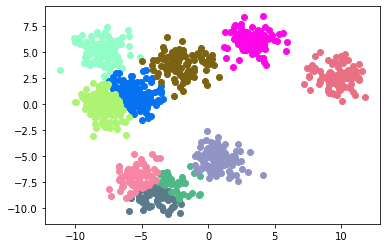

In [4]:
N = 1000
K = 10

points, centroids = make_blobs(n_samples=N, centers=K, n_features=2, random_state=np.random.randint(100))

sol = create_initial_sol(points, K)
sol = simulated_annealing(sol, points, K, 100, 0.99, 100, 0.001)

print("{:.5E}".format(squared_inner_distance(sol, points, K)))

printR2sol(points, sol, K)